# Mini Data Case: Median Household Spending in Nigeria

I modeled the dataset with a logistic regression classification model. The target variable was 'median_spend', or the weighted average of median household spending. Since there was no indication of a particular business use case, this model could be applied for several goals, such as identifying homes with high spending to market for a commercial product or homes with low spending that may be at risk for socio-economic factors. I performed spatial autocorrelation (clustering spatial similarity as well as attribute similarity) on the target variable ('median_spend'). I computed the Moran statistic to identify hot and cold spots within the spatial data, which I converted into two categories, high spend and low spend. The model had an F1 score of 0.77 with an AUC score of 0.90, so the model performed quite well. I choose the F1 score as it is the harmonic mean of precision (the exactness) and recall (completeness). It takes into account false positives and false negatives. F1 is also better when there is a class imbalance, which was present for the high and low spend variables.

I explored and mapped the data in several ways. I found that the independent variables had weak correlations to the target variable (correlation matrix below). I also plotted each variable in a regression line plot to examine their linear relationships with the target variable. Several variables relating to distance had negative relationships with median_spend, indicating that the further the distance from ports, powerplants, accessibility to cities, transmission lines, and roads, the lower the median household spending in Nigeria. I did model the data with a ordinary least squares regression model. The R2 was 0.31, indicating that only 31% of the target variable can be explained by the predictor variables, which is worse than flipping a coin or guessing. With poor OLS model performance and weak correlation variables, I did not pursue a linear regression model further on this dataset.

***

In [280]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
import geopandas as gpd
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import statsmodels.api as sm
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

import esda
from geopandas import GeoDataFrame
import mapclassify as mc
from matplotlib import colors

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

path = 'C:/Users/ariggs/Desktop/Research/'

### Import File

In [808]:
df = pd.read_excel(path + 'nga_median_spend_model_train_data.xlsx')
df.drop(columns=['Unnamed: 0'],inplace=True)
print(df.shape)
df.head(2)

(541, 18)


,median_spend,lat,long,accessibility_to_cities_2015,chirps_2015,chirps_average_2002_2015,distance_to_ports_2012,distance_to_powerplants_2016,distance_to_roads_2015,distance_to_transmission_lines_2016,landscan_population_2017,modis_evi_2000_2016,modis_lst_day_average_2015,modis_lst_night_average_2015,modis_ndvi_2000_2016,sedac_gpw_2015,srtm_2000,viirs_nightlights_2015
0,68483.33,6.23,6.50,1.23,4.11,1918.48,6.11,0.53,1287.48,0.03,1.14,4642.54,27.86,20.20,5933.85,211.80,251.21,0.00
1,576432.00,5.47,7.57,0.90,5.37,2322.15,3.40,0.43,280.80,0.04,1027.56,4314.12,28.69,20.60,5630.92,663.47,119.74,0.26


### Exploratory Data Analysis

Data types and null values - all floats and no missing values for machine learning

In [809]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   median_spend                         541 non-null    float64
 1   lat                                  541 non-null    float64
 2   long                                 541 non-null    float64
 3   accessibility_to_cities_2015         541 non-null    float64
 4   chirps_2015                          541 non-null    float64
 5   chirps_average_2002_2015             541 non-null    float64
 6   distance_to_ports_2012               541 non-null    float64
 7   distance_to_powerplants_2016         541 non-null    float64
 8   distance_to_roads_2015               541 non-null    float64
 9   distance_to_transmission_lines_2016  541 non-null    float64
 10  landscan_population_2017             541 non-null    float64
 11  modis_evi_2000_2016             

Count, std, and upper/lower bounds

In [810]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,median_spend,lat,long,accessibility_to_cities_2015,chirps_2015,chirps_average_2002_2015,distance_to_ports_2012,distance_to_powerplants_2016,distance_to_roads_2015,distance_to_transmission_lines_2016,landscan_population_2017,modis_evi_2000_2016,modis_lst_day_average_2015,modis_lst_night_average_2015,modis_ndvi_2000_2016,sedac_gpw_2015,srtm_2000,viirs_nightlights_2015
count,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00,541.00
mean,119664.58,8.11,7.06,1.88,3.69,1531.36,12.95,1.60,758.51,0.10,3017.84,3098.29,33.24,19.78,4264.89,1618.79,257.89,1.98
std,117803.74,2.41,2.41,1.91,1.38,646.16,8.17,1.53,1298.28,0.18,6016.00,896.95,4.38,1.57,1199.95,4015.63,224.37,4.88
min,13936.00,4.40,2.88,0.10,1.09,363.81,0.69,0.06,0.00,0.00,0.00,648.57,24.57,13.81,709.83,13.40,1.34,0.00
25%,54172.50,6.32,5.05,0.60,2.74,1091.32,6.15,0.43,170.33,0.01,82.93,2326.64,29.27,18.94,3225.00,155.60,67.69,0.00
50%,90300.00,7.52,7.08,1.48,3.46,1412.58,11.10,1.04,365.83,0.03,608.26,3179.06,32.75,20.06,4424.73,357.24,219.92,0.01
75%,140685.00,9.75,8.47,2.54,4.60,1991.28,19.60,2.32,874.63,0.12,3470.89,3875.39,36.92,20.68,5235.94,1074.79,391.36,1.28
max,1092064.00,13.71,13.63,19.60,7.85,3959.34,37.50,7.30,19443.60,1.25,58450.32,4884.86,43.55,22.99,6748.33,35373.10,1304.37,65.61


Skewness

In [811]:
skewed_features = df.apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

distance_to_roads_2015                 7.14
viirs_nightlights_2015                 5.88
sedac_gpw_2015                         4.81
landscan_population_2017               4.29
median_spend                           4.17
accessibility_to_cities_2015           3.65
distance_to_transmission_lines_2016    3.29
srtm_2000                              1.39
distance_to_powerplants_2016           1.37
chirps_2015                            0.59
distance_to_ports_2012                 0.58
lat                                    0.58
chirps_average_2002_2015               0.56
long                                   0.35
modis_lst_day_average_2015             0.30
modis_evi_2000_2016                   -0.12
modis_ndvi_2000_2016                  -0.26
modis_lst_night_average_2015          -0.65
dtype: float64


Distribution - concentration of values at the lower end, some high values - left skewed distribution of the target variable

Text(0.5, 1.0, 'Weighted Average of Median Household Spending in Nigeria')

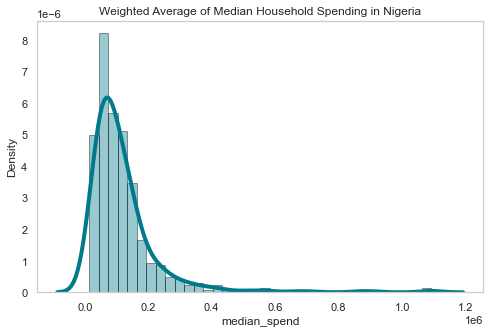

In [812]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8,5))
ax.grid(False)

sns.distplot(df['median_spend'], hist=True, 
             kde=True, 
             bins=int(180/5), color = '#007a8a', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}
            )

ax.set_title("Weighted Average of Median Household Spending in Nigeria", size=12)

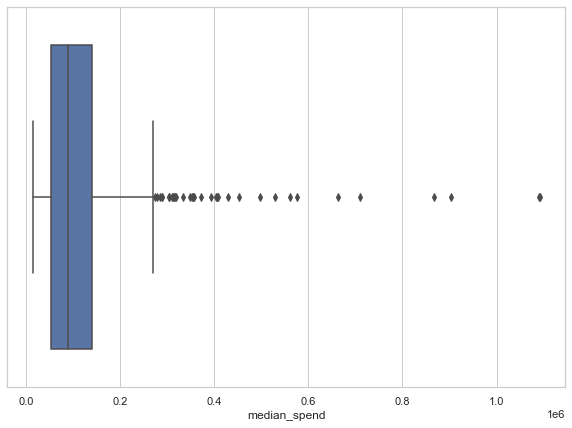

In [813]:
ax = figsize=[8,5]
ax = sns.boxplot(x=df["median_spend"])

Correlation - weak correlation and some negatively correlated variables

In [814]:
corr_matrix = df.corr()
corr_matrix['median_spend'].sort_values(ascending=False)

median_spend                           1.00
modis_lst_night_average_2015           0.43
viirs_nightlights_2015                 0.37
landscan_population_2017               0.35
sedac_gpw_2015                         0.34
chirps_average_2002_2015               0.27
chirps_2015                            0.27
modis_evi_2000_2016                   -0.03
modis_ndvi_2000_2016                  -0.08
distance_to_roads_2015                -0.18
modis_lst_day_average_2015            -0.19
distance_to_transmission_lines_2016   -0.21
accessibility_to_cities_2015          -0.24
long                                  -0.28
srtm_2000                             -0.28
distance_to_powerplants_2016          -0.34
lat                                   -0.35
distance_to_ports_2012                -0.39
Name: median_spend, dtype: float64

<AxesSubplot:>

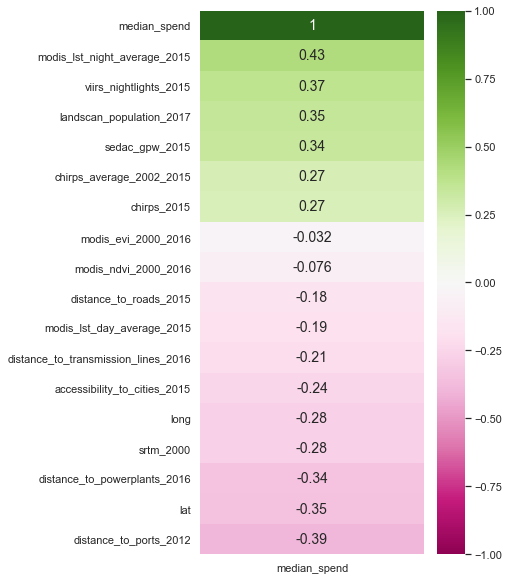

In [817]:
corr_new_train=df.corr()
plt.figure(figsize=(5,10))
sns.heatmap(corr_new_train[['median_spend']].sort_values(by=['median_spend'],ascending=False).head(18),
            annot_kws={"size": 14},vmin=-1, cmap='PiYG', annot=True,
           )

Linear relationship with target variable

In [314]:
len(df.columns)

18

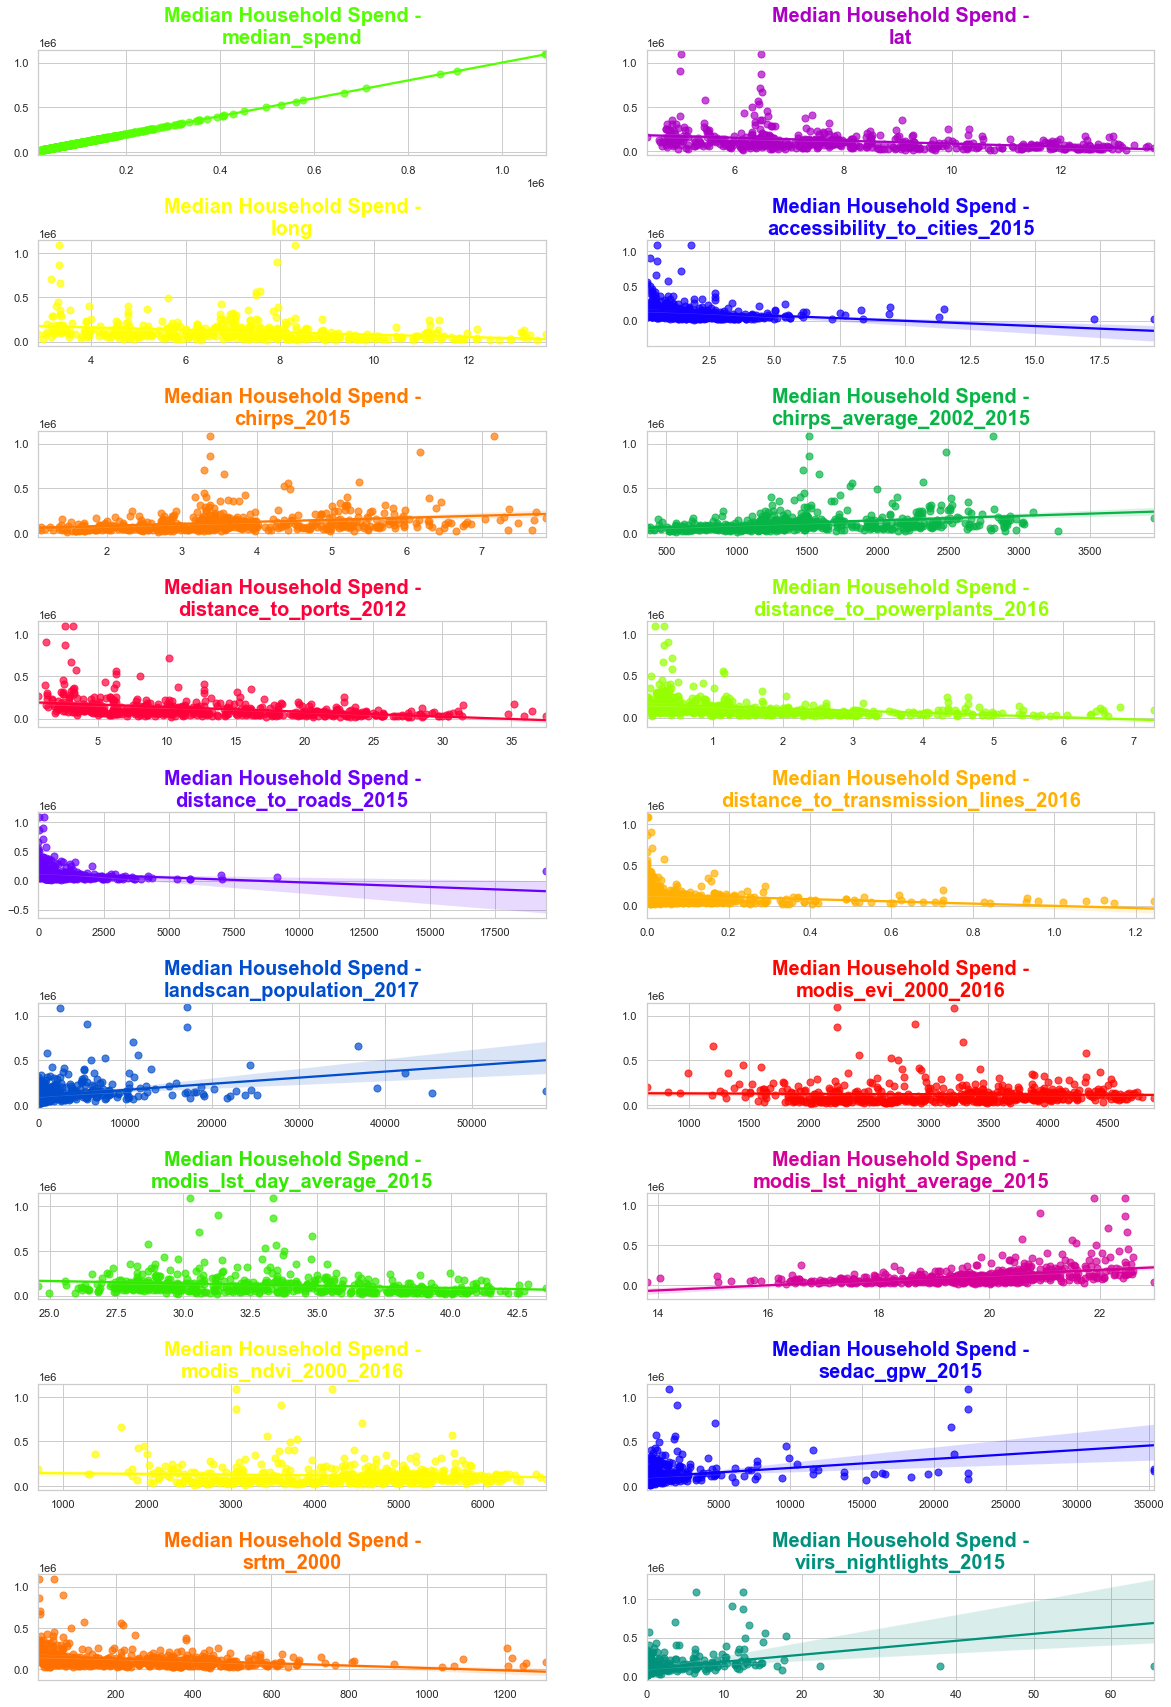

In [354]:
fig, axes = plt.subplots(9, 2,figsize=(20,30))
fig.subplots_adjust(hspace=0.8)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(df.columns))]
for i,ax,color in zip(df.columns,axes.flatten(),colors):
    sns.regplot(x=df[i], y=df["median_spend"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.7},color=color,ax=ax)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    ax.set_title('Median Household Spend'+' -\n'+str(i),color=color,fontweight='bold',size=20)

## Maps

Matplotlib

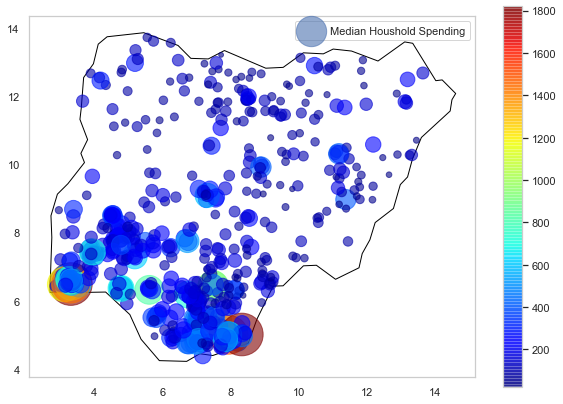

In [320]:
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
nigeria_gdf = world_gdf[(world_gdf['name'] == 'Nigeria')]
plt.rcParams['figure.figsize'] = [10,7]

ax = nigeria_gdf.plot(color='white', edgecolor='black')
ax.grid(False)
plt.scatter(df['long'], df['lat'], 
            s=df['median_spend']/600, 
            label="Median Houshold Spending", alpha=0.6,
            c=df['median_spend']/600, cmap=plt.get_cmap("jet"),
           )
cbar = plt.colorbar()
plt.legend()

Kepler 3D Map

In [215]:
map1=KeplerGl(height=500)
map1.add_data(data=df,name='Median Household Spend in Nigeria')
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Median Household Spend in Nigeria': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

Folium Heatmap

Nigeria Lat/Long - 9.0820° N, 8.6753° E

In [387]:
m = folium.Map(location=[9.0820,8.6753],zoom_start=6)
HeatMap(data=df[['lat', 'long']], radius=10).add_to(m)
m

# Modeling

### Ordinary Least Squares (OLS)

In [818]:
df.columns

Index(['median_spend', 'lat', 'long', 'accessibility_to_cities_2015',
       'chirps_2015', 'chirps_average_2002_2015', 'distance_to_ports_2012',
       'distance_to_powerplants_2016', 'distance_to_roads_2015',
       'distance_to_transmission_lines_2016', 'landscan_population_2017',
       'modis_evi_2000_2016', 'modis_lst_day_average_2015',
       'modis_lst_night_average_2015', 'modis_ndvi_2000_2016',
       'sedac_gpw_2015', 'srtm_2000', 'viirs_nightlights_2015'],
      dtype='object')

In [819]:
df_cols = df[['median_spend', 'lat', 'long', 'accessibility_to_cities_2015',
       'chirps_2015', 'chirps_average_2002_2015', 'distance_to_ports_2012',
       'distance_to_powerplants_2016', 'distance_to_roads_2015',
       'distance_to_transmission_lines_2016', 'landscan_population_2017',
       'modis_evi_2000_2016', 'modis_lst_day_average_2015',
       'modis_lst_night_average_2015', 'modis_ndvi_2000_2016',
       'sedac_gpw_2015', 'srtm_2000', 'viirs_nightlights_2015',]]

# define x and y
X = df_cols.drop('median_spend',axis=1)
y = df_cols['median_spend']

In [821]:
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
# results.params
# results.tvalues

In [822]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           median_spend   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     14.06
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.54e-33
Time:                        15:23:50   Log-Likelihood:                -6982.5
No. Observations:                 541   AIC:                         1.400e+04
Df Residuals:                     523   BIC:                         1.408e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [823]:
# print("Parameters: ", results.params)
# print("R2: ", results.rsquared)

## Spatial Autocorrelation & Hot Spot Analysis

- EPSG Code for Nigeria - 26392
- Nigeria Lat/Long - 9.0820° N, 8.6753° E

In [825]:
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
# Set the coordinate reference system (CRS) to EPSG 4326
df.crs = {'init': 'epsg:4326'}

In [826]:
df.columns

Index(['median_spend', 'lat', 'long', 'accessibility_to_cities_2015',
       'chirps_2015', 'chirps_average_2002_2015', 'distance_to_ports_2012',
       'distance_to_powerplants_2016', 'distance_to_roads_2015',
       'distance_to_transmission_lines_2016', 'landscan_population_2017',
       'modis_evi_2000_2016', 'modis_lst_day_average_2015',
       'modis_lst_night_average_2015', 'modis_ndvi_2000_2016',
       'sedac_gpw_2015', 'srtm_2000', 'viirs_nightlights_2015', 'geometry'],
      dtype='object')

In [827]:
df_cols2 = df[['median_spend', 'lat', 'long', 'accessibility_to_cities_2015',
       'chirps_2015', 'chirps_average_2002_2015', 'distance_to_ports_2012',
       'distance_to_powerplants_2016', 'distance_to_roads_2015',
       'distance_to_transmission_lines_2016', 'landscan_population_2017',
       'modis_evi_2000_2016', 'modis_lst_day_average_2015',
       'modis_lst_night_average_2015', 'modis_ndvi_2000_2016',
       'sedac_gpw_2015', 'srtm_2000', 'viirs_nightlights_2015','geometry']]

In [772]:
# fig, ax = plt.subplots(figsize=(9,9), subplot_kw={'aspect':'equal'})
# ax.grid(False)
# merged.plot(column='median_spend', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)
# plt.title("Median Spend (Quantiles)")

Apply spatial similarity weights from PySAL to see if points are geographically similar

In [795]:
merged = GeoDataFrame(df_cols2)

In [796]:
gdf2 = merged
wq =  ps.weights.Queen.from_dataframe(gdf2)
wq.transform = 'r'

Add a spatial lag to see if the points share an attribute similarity in addition to geographic similarity

In [797]:
y = gdf2['median_spend']
ylag = ps.weights.lag_spatial(wq, y)

In [798]:
ylagq5 = mc.Quantiles(ylag, k=5)

In [803]:
# f, ax = plt.subplots(1, figsize=(9, 9))
# ax.grid(False)
# gdf2.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
#         k=5, cmap='GnBu', linewidth=0.2, ax=ax, \
#         edgecolor='k', legend=True,)
# plt.title("Spatial Lag Median Spend (Quintiles)")

# plt.show()

Compare Spatial and Attribute Similarity

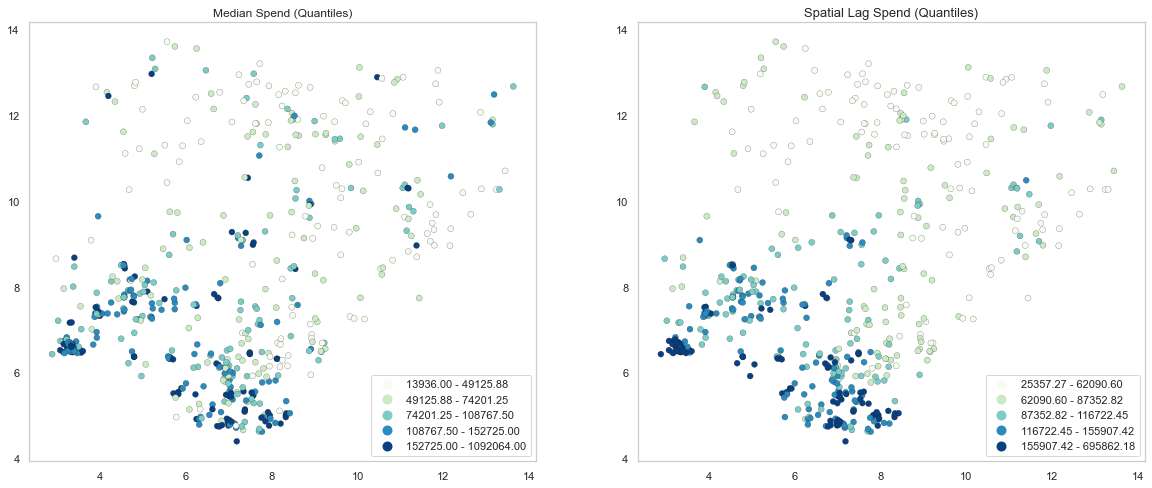

In [771]:
gdf2['lag_median_spend'] = ylag
f,ax = plt.subplots(1,2,figsize=(20,15))
gdf2.plot(column='median_spend', ax=ax[0], edgecolor='k',linewidth=0.2,
        scheme="quantiles",  k=5, cmap='GnBu',legend=True)
ax[0].set_title("Median Spend (Quantiles)")
ax[0].grid(False)
gdf2.plot(column='lag_median_spend', ax=ax[1], edgecolor='k',linewidth=0.2,
        scheme='quantiles', cmap='GnBu', k=5,legend=True)
ax[1].set_title("Spatial Lag Spend (Quantiles)")
ax[1].grid(False)

plt.show()

Get median of the Median Spend variable and divide points into high and low to create a binary attribute and visualize

In [700]:
y.median()

90300.0

In [701]:
yb = y > y.median()
sum(yb)

270

In [703]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
gdf2['yb'] = yb

<AxesSubplot:>

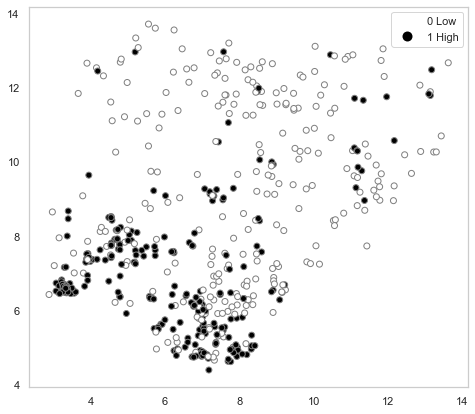

In [773]:
fig, ax = plt.subplots(figsize=(9,7), subplot_kw={'aspect':'equal'})
ax.grid(False)
gdf2.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

Use Moran's I test for autocorrelation

In [774]:
wq.transform = 'r'

In [775]:
y = gdf2['median_spend']

In [776]:
mi = esda.moran.Moran(y, wq)
mi.I

0.28118045726468816

In [777]:
mi.p_sim #single point is statistically significant

0.001

In [ ]:
# sbn.kdeplot(mi.sim, shade=True)
# plt.vlines(mi.I, 0, 1, color='r')
# plt.vlines(mi.EI, 0,1)
# plt.xlabel("Moran's I")

Spatial association is detected in the four quadrants of the Moran scatterplot

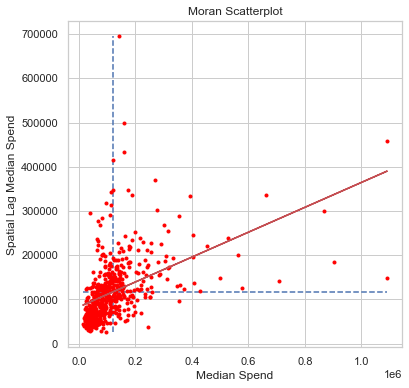

In [780]:
wq.transform = 'r'
lag_spend = ps.weights.lag_spatial(wq, gdf2['median_spend'])

spend = gdf2['median_spend']
b, a = np.polyfit(spend, lag_spend, 1)
f, ax = plt.subplots(1, figsize=(6, 6))

plt.plot(spend, lag_spend, '.', color='red')

 # dashed vert at mean of the spend
plt.vlines(spend.mean(), lag_spend.min(), lag_spend.max(), linestyle='--')
 # dashed horizontal at mean of lagged spend
plt.hlines(lag_spend.mean(), spend.min(), spend.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(spend, a + b*spend, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag Median Spend')
plt.xlabel('Median Spend')
plt.show()

In [781]:
li = esda.moran.Moran_Local(y, wq)

In [829]:
len(gdf2)

541

In [831]:
(li.p_sim < 0.05).sum()

158

In [832]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [833]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

Visualization of quadrant 1 on Moran scatterplot - Hot Spots

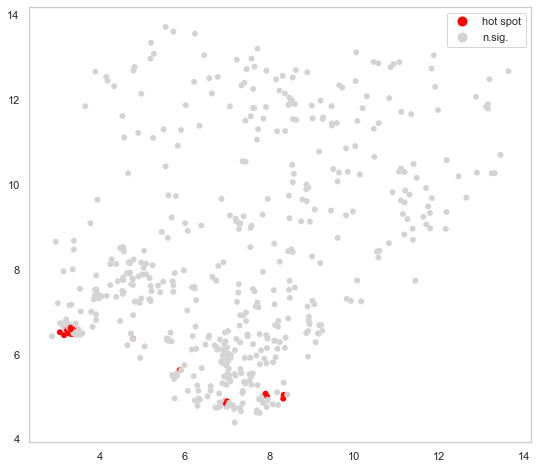

In [834]:
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
ax.grid(False)
gdf2.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
# ax.set_axis_off()
plt.show()

In [786]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

In [787]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

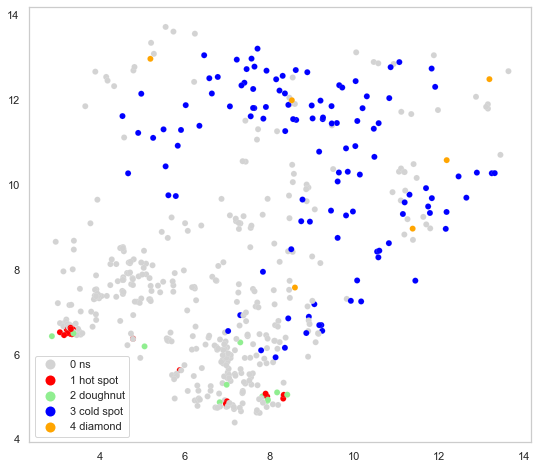

In [791]:
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightgreen', 'blue', 'orange'])
f, ax = plt.subplots(1, figsize=(9, 9))
ax.grid(False)
gdf2.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
# ax.set_axis_off()
plt.show()

In [840]:
len(li.q)

541

In [872]:
n_array = li.q
df['moran_clusters'] = pd.Series(n_array, index=df.index)
# df.head(2)

## Logistic Regression
- Binary classification - median spend was segmented into high and low spend categories based on the clustering segements of median_spend

In [843]:
df.columns

Index(['median_spend', 'lat', 'long', 'accessibility_to_cities_2015',
       'chirps_2015', 'chirps_average_2002_2015', 'distance_to_ports_2012',
       'distance_to_powerplants_2016', 'distance_to_roads_2015',
       'distance_to_transmission_lines_2016', 'landscan_population_2017',
       'modis_evi_2000_2016', 'modis_lst_day_average_2015',
       'modis_lst_night_average_2015', 'modis_ndvi_2000_2016',
       'sedac_gpw_2015', 'srtm_2000', 'viirs_nightlights_2015', 'geometry',
       'moran_clusters'],
      dtype='object')

In [844]:
df['moran_clusters'].value_counts().sort_index()

1    121
2     86
3    271
4     63
Name: moran_clusters, dtype: int64

In [852]:
df.loc[df['moran_clusters'] == 1,'SpendSegment'] = 'High Spend'  #hot spots
df.loc[df['moran_clusters'] == 2,'SpendSegment'] = 'High Spend' 
df.loc[df['moran_clusters'] == 3,'SpendSegment'] = 'Low Spend'  #cold spots
df.loc[df['moran_clusters'] == 4,'SpendSegment'] = 'Low Spend' 

In [853]:
df['SpendSegment'].value_counts()

Low Spend     334
High Spend    207
Name: SpendSegment, dtype: int64

In [854]:
df_cols = df[['SpendSegment', 'lat', 'long', 'accessibility_to_cities_2015',
       'chirps_2015', 'chirps_average_2002_2015', 'distance_to_ports_2012',
       'distance_to_powerplants_2016', 'distance_to_roads_2015',
       'distance_to_transmission_lines_2016', 'landscan_population_2017',
       'modis_evi_2000_2016', 'modis_lst_day_average_2015',
       'modis_lst_night_average_2015', 'modis_ndvi_2000_2016',
       'sedac_gpw_2015', 'srtm_2000', 'viirs_nightlights_2015',]]

In [855]:
# define x and y
X = df_cols.drop('SpendSegment',axis=1)
y = df_cols['SpendSegment']

In [856]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [857]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(362, 17)
(179, 17)
(362,)
(179,)


In [859]:
lr = LogisticRegression(penalty = 'l2', solver='lbfgs', random_state=42)

In [860]:
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [861]:
y_pred_ridge = lr.predict(X_test)

In [862]:
print('Training set score: {:.4f}'.format(lr.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lr.score(X_test, y_test)))

Training set score: 0.8204
Test set score: 0.7709


In [863]:
cm = confusion_matrix(y_test, y_pred_ridge)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[53 18]
 [23 85]]

True Positives(TP) =  53

True Negatives(TN) =  85

False Positives(FP) =  18

False Negatives(FN) =  23


In [864]:
print(classification_report(y_test, y_pred_ridge))

              precision    recall  f1-score   support

  High Spend       0.70      0.75      0.72        71
   Low Spend       0.83      0.79      0.81       108

    accuracy                           0.77       179
   macro avg       0.76      0.77      0.76       179
weighted avg       0.77      0.77      0.77       179



In [865]:
roc_auc_score(y, lr.predict_proba(X)[:, 1])

0.9005033411437994

In [867]:
feature_importance = lr.coef_.T

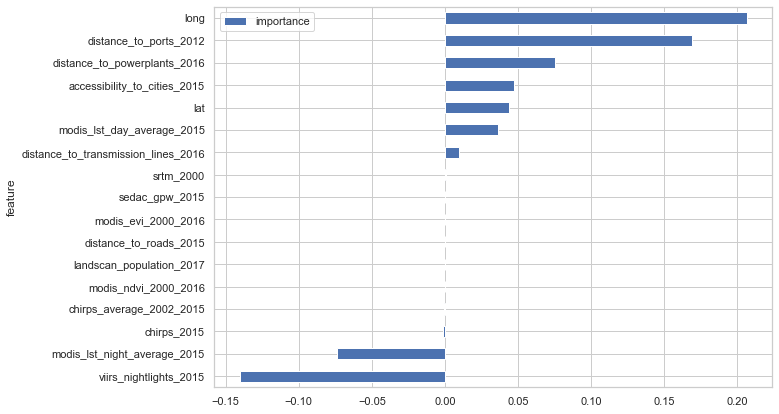

In [868]:
df_importance = pd.DataFrame(X.columns, columns = ["feature"])
df_importance["importance"] = feature_importance
df_importance = df_importance.sort_values(by = ["importance"], ascending=True)
ax = df_importance.plot.barh(x='feature', y='importance')
plt.show()

## END

***